# To train the model, at first i used **Detectron2 Model**, but even after training 4000+ epochs, it segmented the images very badly,
# So, i trained again a new model with **YOLOv8**, and got significant success there, so u want to see the [**required results**] -> see the **YOLOv8 Portion**;

## **DETECTRON2 starts from here**

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.4 ; cuda:  cu121
detectron2: 0.6


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/coco_sample_dataset_ref_toothlens/anno_train/00000001_annotations.coco_cleaned.json", "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/coco_sample_dataset_ref_toothlens/train")
register_coco_instances("my_dataset_val", {}, "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/coco_sample_dataset_ref_toothlens/anno_test/_annotations.coco.json", "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/coco_sample_dataset_ref_toothlens/test")


In [ ]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[09/28 17:34:27 d2.data.datasets.coco]: Loading /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/coco_sample_dataset_ref_toothlens/anno_train/00000001_annotations.coco_cleaned.json takes 1.24 seconds.
WARNING [09/28 17:34:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/28 17:34:27 d2.data.datasets.coco]: Loaded 1737 images in COCO format from /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/coco_sample_dataset_ref_toothlens/anno_train/00000001_annotations.coco_cleaned.json
WARNING [09/28 17:34:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/28 17:34:27 d2.data.datasets.coco]: Loaded 133 images in COCO format from /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/coco_sample_dataset_ref_toothlens/anno_test/_annotations.coco.json


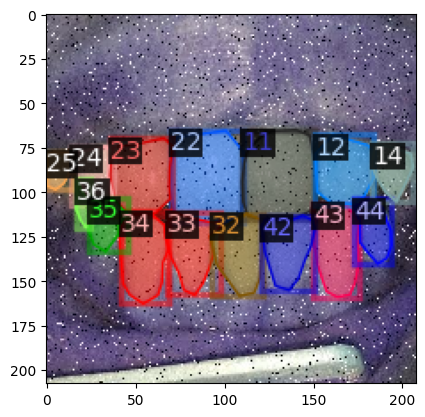

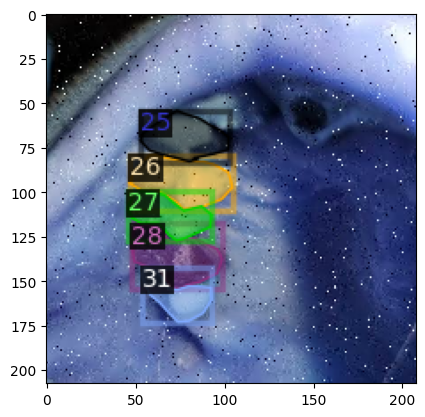

In [ ]:
from matplotlib import pyplot as plt
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()


In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
# from detectron2.engine import DefaultTrainer
# cfg = get_cfg()
# cfg.OUTPUT_DIR = "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/model_storage"
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.DATASETS.TRAIN = ("my_dataset_train",)
# cfg.DATASETS.TEST = ()
# cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.00025
# cfg.SOLVER.MAX_ITER = 2500
# cfg.SOLVER.STEPS = []
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6
# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=False)





import os
import torch
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog
import random
import locale

locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/model_storage"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
register_coco_instances(
    "my_dataset_train",
    {},
    "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/coco_sample_dataset_ref_toothlens/anno_train/00000001_annotations.coco_cleaned.json",
    "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/coco_sample_dataset_ref_toothlens/train"
)
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 2000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 35
cfg.MODEL.DEVICE = "cuda"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
dataset_dicts = DatasetCatalog.get("my_dataset_train")
for d in random.sample(dataset_dicts, 3):
    print(d["annotations"])




[09/28 17:35:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 139MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


WARNING [09/28 17:35:33 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/28 17:35:33 d2.data.datasets.coco]: Loaded 1737 images in COCO format from /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/coco_sample_dataset_ref_toothlens/anno_train/00000001_annotations.coco_cleaned.json
[{'iscrowd': 0, 'bbox': [176, 125, 109.378, 62.664], 'category_id': 10, 'segmentation': [[196.538, 128.656, 176.03, 134.922, 176.03, 143.467, 182.296, 154.291, 187.423, 163.975, 199.956, 164.545, 214.198, 166.254, 230.719, 169.103, 239.264, 167.394, 247.239, 180.496, 261.481, 185.053, 275.153, 187.332, 285.408, 183.344, 285.408, 167.963, 279.711, 152.582, 274.014, 137.201, 268.317, 131.504, 251.227, 127.516, 231.288, 124.668, 209.641, 124.668, 196.538, 128.656]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [132, 139, 53.55, 42.726], 'category_id': 11, 'segmentation': [[132.165, 174.23, 150.964, 178.217, 159.509, 

In [ ]:
# the dataset provided to me from ROBOFLOW, had many issues with the dataset images and annotations,
# it took me ~1day to find out exactly what images and annotations were broken and removed it manually through code;

In [ ]:
import json

# Path to your COCO JSON file
coco_json_path = "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/coco_sample_dataset_ref_toothlens/anno_train/00000001_annotations.coco_cleaned.json"

# Load the COCO JSON
with open(coco_json_path, 'r') as f:
    coco_data = json.load(f)

# Check all annotations for valid masks
invalid_masks = []
for annotation in coco_data['annotations']:
    # Ensure the annotation has a valid segmentation
    if 'segmentation' not in annotation or not annotation['segmentation']:
        invalid_masks.append(annotation['image_id'])
    # Check for out-of-bound or incorrect mask format
    if isinstance(annotation['segmentation'], list):  # Polygon mask
        for segment in annotation['segmentation']:
            if len(segment) < 6:  # Polygon needs at least 3 points
                invalid_masks.append(annotation['image_id'])
    elif isinstance(annotation['segmentation'], dict):  # RLE mask
        if 'size' not in annotation['segmentation'] or 'counts' not in annotation['segmentation']:
            invalid_masks.append(annotation['image_id'])

# Output any issues
if invalid_masks:
    print(f"Found {len(invalid_masks)} invalid masks in the dataset.")
    for img_id in invalid_masks:
        print(f"Image ID with invalid mask: {img_id}")
else:
    print("All masks are valid.")


All masks are valid.


In [ ]:
import json
import os

# Path to your COCO JSON file and dataset directory
coco_json_path = "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/coco_sample_dataset_ref_toothlens/anno_train/00000001_annotations.coco.json"
image_dir = "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/coco_sample_dataset_ref_toothlens/train/"

# List of invalid image IDs found earlier
invalid_image_ids = [333, 1046, 1625]

# Load the COCO JSON file
with open(coco_json_path, 'r') as f:
    coco_data = json.load(f)

# Filter out invalid annotations and images
new_annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] not in invalid_image_ids]
new_images = [img for img in coco_data['images'] if img['id'] not in invalid_image_ids]

# Update the COCO JSON structure
coco_data['annotations'] = new_annotations
coco_data['images'] = new_images

# Save the updated JSON file
new_coco_json_path = coco_json_path.replace('.json', '_cleaned.json')
with open(new_coco_json_path, 'w') as f:
    json.dump(coco_data, f, indent=4)

print(f"Updated COCO JSON saved to: {new_coco_json_path}")


Updated COCO JSON saved to: /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/coco_sample_dataset_ref_toothlens/anno_train/00000001_annotations.coco_cleaned.json


In [ ]:
import os

# Check permissions for the directory
dir_path = "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/coco_sample_dataset_ref_toothlens/train"
print(os.access(dir_path, os.W_OK))


True


In [ ]:
# Loop through the invalid image IDs and remove corresponding files from the dataset
for img in coco_data['images']:
    if img['id'] in invalid_image_ids:
        img_path = os.path.join(image_dir, img['file_name'])
        if os.path.exists(img_path):
            os.remove(img_path)
            print(f"Removed image: {img_path}")
        else:
            print(f"Image not found: {img_path}")


In [ ]:
# initially trained for 2000 epochs;

In [ ]:
trainer.train()

[09/28 17:36:29 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/28 17:36:43 d2.utils.events]:  eta: 0:14:45  iter: 19  total_loss: 5.66  loss_cls: 3.509  loss_box_reg: 0.8716  loss_mask: 0.6936  loss_rpn_cls: 0.6151  loss_rpn_loc: 0.0658    time: 0.4629  last_time: 0.3799  data_time: 0.1477  last_data_time: 0.0075   lr: 4.9953e-06  max_mem: 1772M
[09/28 17:36:58 d2.utils.events]:  eta: 0:16:17  iter: 39  total_loss: 5.363  loss_cls: 3.316  loss_box_reg: 0.9069  loss_mask: 0.6937  loss_rpn_cls: 0.4219  loss_rpn_loc: 0.06333    time: 0.5065  last_time: 0.6633  data_time: 0.1693  last_data_time: 0.3514   lr: 9.9902e-06  max_mem: 1772M
[09/28 17:37:10 d2.utils.events]:  eta: 0:16:20  iter: 59  total_loss: 4.817  loss_cls: 2.923  loss_box_reg: 0.8544  loss_mask: 0.6927  loss_rpn_cls: 0.2187  loss_rpn_loc: 0.0662    time: 0.5317  last_time: 0.6352  data_time: 0.2050  last_data_time: 0.2121   lr: 1.4985e-05  max_mem: 1772M
[09/28 17:37:20 d2.utils.events]:  eta: 0:16:03  iter: 79  total_loss: 3.959  loss_cls: 2.289  loss_box_reg: 0.8684  loss_mask: 0.

In [ ]:
import json

with open("/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/coco_sample_dataset_ref_toothlens/anno_train/00000001_annotations.coco.json") as f:
    annotations = json.load(f)
    print(annotations)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# dataset_dicts = DatasetCatalog.get("my_dataset_train")
# for d in random.sample(dataset_dicts, 3):
#     if "gt_masks" not in d:
#         print(f"Missing gt_masks in: {d['file_name']}")


In [ ]:
# from detectron2.data import DatasetCatalog

# dataset_dicts = DatasetCatalog.get("my_dataset_train")
# for d in dataset_dicts:
#     if "gt_masks" not in d:
#         print(f"Missing gt_masks in: {d['file_name']}")

In [ ]:
import yaml
config_yaml_path = "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/model_storage/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/model_storage/model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

[09/28 17:53:14 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/model_storage/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

In [ ]:
# then re-trained or 2000 epochs more from where i left the training;

In [ ]:
import os
import torch
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog
import random
import locale
import yaml

# Set locale for proper formatting
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

# Configure the Detectron2 training
cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/model_storage"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
register_coco_instances(
    "my_dataset_train",
    {},
    "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/coco_sample_dataset_ref_toothlens/anno_train/00000001_annotations.coco_cleaned.json",
    "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/coco_sample_dataset_ref_toothlens/train"
)
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Use the last checkpoint
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 4000  # Total iterations (2000 + 2000)
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 35
cfg.MODEL.DEVICE = "cuda"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Initialize trainer and resume training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)  # Set resume=True to continue training


[09/28 18:08:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[09/28 18:08:43 d2.engine.hooks]: Loading scheduler from state_dict ...


In [ ]:
trainer.train()

[09/28 18:09:01 d2.engine.train_loop]: Starting training from iteration 2000
[09/28 18:09:10 d2.utils.events]:  eta: 0:13:20  iter: 2019  total_loss: 1.381  loss_cls: 0.7313  loss_box_reg: 0.392  loss_mask: 0.2241  loss_rpn_cls: 0.007034  loss_rpn_loc: 0.03396    time: 0.4026  last_time: 0.3832  data_time: 0.0246  last_data_time: 0.0069   lr: 0.00025  max_mem: 1938M
[09/28 18:09:18 d2.utils.events]:  eta: 0:13:01  iter: 2039  total_loss: 1.409  loss_cls: 0.8144  loss_box_reg: 0.3547  loss_mask: 0.2161  loss_rpn_cls: 0.01306  loss_rpn_loc: 0.02928    time: 0.4015  last_time: 0.4086  data_time: 0.0067  last_data_time: 0.0066   lr: 0.00025  max_mem: 1939M
[09/28 18:09:26 d2.utils.events]:  eta: 0:12:54  iter: 2059  total_loss: 1.406  loss_cls: 0.7531  loss_box_reg: 0.4005  loss_mask: 0.2436  loss_rpn_cls: 0.008405  loss_rpn_loc: 0.03548    time: 0.4034  last_time: 0.4316  data_time: 0.0133  last_data_time: 0.0059   lr: 0.00025  max_mem: 1939M
[09/28 18:09:34 d2.utils.events]:  eta: 0:12:4

In [ ]:
# Sample and print annotations for a few images
dataset_dicts = DatasetCatalog.get("my_dataset_train")
for d in random.sample(dataset_dicts, 3):
    print(d["annotations"])

WARNING [09/28 18:24:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/28 18:24:25 d2.data.datasets.coco]: Loaded 1737 images in COCO format from /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/coco_sample_dataset_ref_toothlens/anno_train/00000001_annotations.coco_cleaned.json
[{'iscrowd': 0, 'bbox': [353, 291, 60.49, 41.388], 'category_id': 10, 'segmentation': [[391.592, 311.337, 355.51, 291.173, 353.388, 310.806, 364, 325.663, 413.878, 332.561, 412.286, 326.194, 391.592, 311.337]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [292, 261, 61.02, 61.02], 'category_id': 11, 'segmentation': [[325.796, 322.48, 353.388, 313.459, 352.857, 289.582, 327.918, 275.255, 295.02, 261.459, 292.367, 282.684, 296.082, 311.867, 312.531, 318.235, 325.796, 322.48]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [240, 239, 53.592, 86.49], 'category_id': 12, 'segmentation': [[249.388, 324.071,

In [ ]:
# Save the updated config
config_yaml_path = "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/model_storage/config_V2.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

# Set up predictor for inference
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

[09/28 18:24:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/model_storage/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

In [ ]:
# showing very very bad results

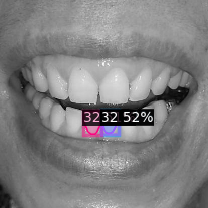

In [ ]:
from detectron2.utils.visualizer import ColorMode
for d in random.sample(val_dataset_dicts, 1):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[09/28 18:26:21 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [09/28 18:26:21 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/28 18:26:21 d2.data.datasets.coco]: Loaded 133 images in COCO format from /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/coco_sample_dataset_ref_toothlens/anno_test/_annotations.coco.json
[09/28 18:26:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/28 18:26:21 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/28 18:26:21 d2.data.common]: Serializing 133 elements to byte tensors and concatenating them all ...
[09/28 18:26:21 d2.data.common]: Serialized dataset takes 0.40 MiB
[09/28 18:26:21 d2.evaluation.evaluator]: Start inference on 133 batches

In [ ]:
# taking a random image from the set and got no segmentation, clearly DETECTRON2 failed;

In [ ]:
new_im = cv2.imread("/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/coco_sample_dataset_ref_toothlens/test/022_00069_07_c031.rf.cb6ab10a7f9e745ec1ad4aaed9459114.jpg")
outputs  = predictor(new_im)

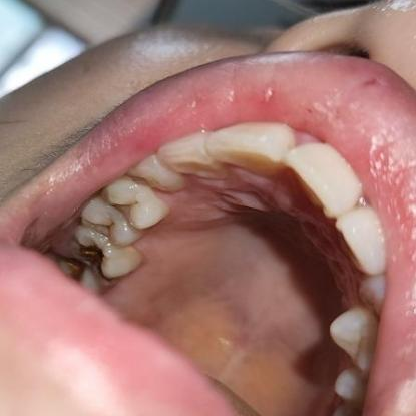

In [ ]:
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
input_images_directory = "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/TOOTHLENS_DATASET_missing_teeth_test_images"
output_directory = "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/predicted_detected_segmented_results"
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)
    outputs = predictor(new_im)
    v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])
print("Segmentation of all images completed.")

Segmentation of all images completed.


In [ ]:
import csv
from skimage.measure import regionprops, label
input_images_directory = "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/TOOTHLENS_DATASET_missing_teeth_test_images"
output_csv_path = "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/predicted_detected_segmented_results/output_recognized_objects.csv"
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["File Name", "Class Name", "Object Number", "Area", "Centroid", "BoundingBox"])
    for image_filename in os.listdir(input_images_directory):
        image_path = os.path.join(input_images_directory, image_filename)
        new_im = cv2.imread(image_path)
        if new_im is not None:
            outputs = predictor(new_im)
            mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)
            class_labels = outputs["instances"].pred_classes.to("cpu").numpy()
            labeled_mask = label(mask)
            if labeled_mask.size > 0:
                props = regionprops(labeled_mask)
                for i, prop in enumerate(props):
                    object_number = i + 1
                    area = prop.area
                    centroid = prop.centroid
                    bounding_box = prop.bbox
                    if i < len(class_labels):
                        class_label = class_labels[i]
                        class_name = train_metadata.thing_classes[class_label]
                    else:
                        class_name = 'Unknown'
                    csvwriter.writerow([image_filename, class_name, object_number, area, centroid, bounding_box])

print("Object-level information saved to CSV file.")


Object-level information saved to CSV file.


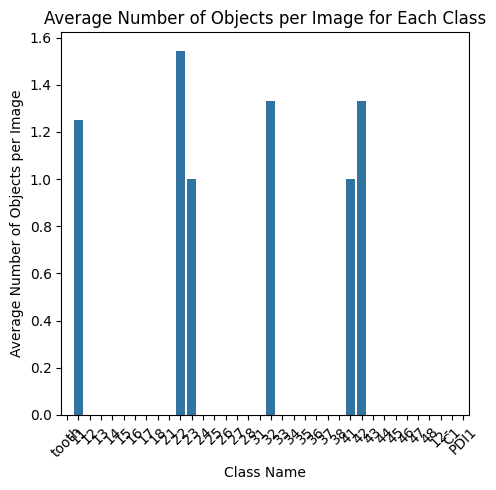

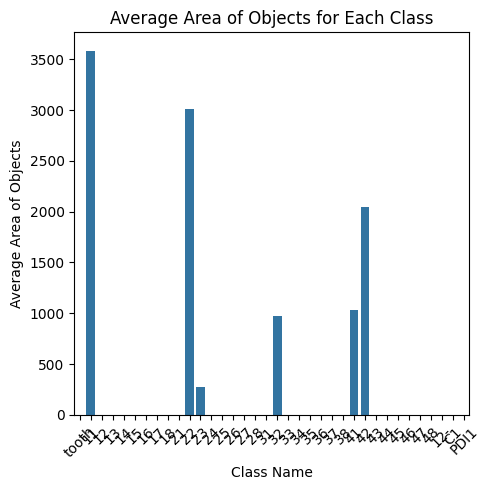

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
csv_file_path = "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/predicted_detected_segmented_results/output_recognized_objects.csv"
df = pd.read_csv(csv_file_path)
class_names = train_metadata.thing_classes
avg_objects_per_class = df.groupby(["File Name", "Class Name"])["Object Number"].count().reset_index()
avg_objects_per_class = avg_objects_per_class.groupby("Class Name")["Object Number"].mean().reset_index()
plt.figure(figsize=(5, 5))
sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, errorbar=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Number of Objects per Image")
plt.title("Average Number of Objects per Image for Each Class")
plt.tight_layout()
plt.show()
avg_area_per_class = df.groupby("Class Name")["Area"].mean().reset_index()
plt.figure(figsize=(5, 5))
sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, errorbar=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Area of Objects")
plt.title("Average Area of Objects for Each Class")
plt.tight_layout()
plt.show()

In [ ]:
import os
import cv2
import numpy as np
import torch
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
predictor = detectron2.engine.defaults.DefaultPredictor(cfg)
train_metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
input_images_directory = "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/TOOTHLENS_DATASET_missing_teeth_test_images"
output_directory = "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/predicted_ground_truth_images"
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)
    if new_im is not None:
        outputs = predictor(new_im)
        if len(outputs["instances"].pred_masks) > 0:
            class_masks = {class_name: torch.zeros_like(outputs["instances"].pred_masks[0], dtype=torch.uint8, device=torch.device("cuda:0"))
                        for class_name in train_metadata.thing_classes}
            for i, pred_class in enumerate(outputs["instances"].pred_classes):
                class_name = train_metadata.thing_classes[pred_class]
                class_masks[class_name] = torch.where(outputs["instances"].pred_masks[i].to(device=torch.device("cuda:0")),
                                                    i + 1,
                                                    class_masks[class_name])
            for class_name, class_mask in class_masks.items():
                class_mask_np = class_mask.cpu().numpy()
                class_filename = os.path.splitext(image_filename)[0] + f"_{class_name}_result.png"
                class_output_path = os.path.join(output_directory, class_filename)
                cv2.imwrite(class_output_path, class_mask_np.astype(np.uint8))
print("Segmentation of all images completed.")

[09/28 18:38:15 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/model_storage/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

Segmentation of all images completed.


*italicized text*## **YOLOv8 STARTS FROM HERE**

### After **DETECTRON2** failed, i again trained a new model on YOLOv8, here i got significant good results;
### the dataset from ROBOFLOW, had no annomalities into .txt annotation files for **YOLOv8**;

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.3/881.3 kB 22.2 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
from matplotlib import pyplot as plt
from PIL import Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model = YOLO('yolov8n-seg.yaml') # building a model of instance segmentation, this only brings the structure with random weights;
model = YOLO('yolov8n-seg.pt') # now, filling thats trcuture with random weights;

100%|██████████| 6.74M/6.74M [00:00<00:00, 110MB/s]


In [ ]:
# number of classes based on YAML, basically reading the YAML, as the YAMLfile contains all the info, the no of classes, the path of test(if any), train, val images;
import yaml
with open("/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/yolov8_sample_dataset_ref_toothlens/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
num_classes

'35'

In [ ]:
%cat "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/yolov8_sample_dataset_ref_toothlens/data.yaml"

train: /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/yolov8_sample_dataset_ref_toothlens/train
val: /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/yolov8_sample_dataset_ref_toothlens/test


nc: 35
names: ['11', '12', '12-', '13', '14', '15', '16', '17', '18', '21', '22', '23', '24', '25', '26', '27', '28', '31', '32', '33', '34', '35', '36', '37', '38', '41', '42', '43', '44', '45', '46', '47', '48', 'C1', 'PDI1']


In [ ]:
# checked for any annomalities, but no annomality;

In [ ]:
import os

# Path to your YOLO dataset (where images and .txt annotations are stored)
dataset_path = "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/yolov8_sample_dataset_ref_toothlens/train"

# Function to check if the annotation is corrupted
def check_annotation_file(txt_file):
    with open(txt_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            values = line.strip().split()
            # Valid YOLO annotations have at least 5 values per line (class, x_center, y_center, width, height)
            if len(values) != 5:
                return False
    return True

# Get all .txt files in the dataset
corrupted_files = []
for txt_file in os.listdir(dataset_path):
    if txt_file.endswith('.txt'):
        txt_file_path = os.path.join(dataset_path, txt_file)
        if not check_annotation_file(txt_file_path):
            corrupted_files.append(txt_file_path)

# Output corrupted .txt files
if corrupted_files:
    print(f"Found {len(corrupted_files)} corrupted annotation files:")
    for corrupt in corrupted_files:
        print(corrupt)
else:
    print("No corrupted annotation files found.")


No corrupted annotation files found.


In [ ]:
# start the training

project = "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/Yolo_Result_Training"
name = "30_epochs-"

In [ ]:
results = model.train(data="/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/yolov8_sample_dataset_ref_toothlens/data.yaml", # --> the data is only the yaml file, as this only says where the training and val data staying;
                      project=project, # the project directory;
                      name=name,
                      epochs=30,
                      patience=0,
                      batch=4,
                      imgsz=800)


Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/yolov8_sample_dataset_ref_toothlens/data.yaml, epochs=30, time=None, patience=0, batch=4, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/Yolo_Result_Training, name=30_epochs-2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=Fal

train: Scanning /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/yolov8_sample_dataset_ref_toothlens/train/labels... 1740 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1740/1740 [11:37<00:00,  2.49it/s]


train: New cache created: /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/yolov8_sample_dataset_ref_toothlens/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/yolov8_sample_dataset_ref_toothlens/test/labels... 133 images, 0 backgrounds, 0 corrupt: 100%|██████████| 133/133 [01:00<00:00,  2.19it/s]

val: New cache created: /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/yolov8_sample_dataset_ref_toothlens/test/labels.cache


Plotting labels to /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/Yolo_Result_Training/30_epochs-2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000256, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 800 train, 800 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/Yolo_Result_Training/30_epochs-2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.57G      1.341      2.572      4.218      1.304         68        800: 100%|██████████| 435/435 [02:31<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  4.98it/s]

                   all        133       1398      0.309       0.18      0.065     0.0496      0.309       0.18     0.0644     0.0469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.66G      1.178      1.965      3.098      1.182         75        800: 100%|██████████| 435/435 [02:22<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:02<00:00,  5.81it/s]


                   all        133       1398      0.259      0.335      0.134     0.0994      0.258      0.333      0.132     0.0952

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.48G       1.12      1.847      2.716      1.137         63        800: 100%|██████████| 435/435 [02:21<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:04<00:00,  4.00it/s]


                   all        133       1398       0.23      0.432      0.177      0.132      0.224      0.429      0.173      0.125

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.6G      1.059       1.72      2.482      1.096         57        800: 100%|██████████| 435/435 [02:20<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  4.72it/s]


                   all        133       1398      0.177      0.496      0.202      0.149      0.174      0.489      0.194      0.141

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.64G      1.039      1.683      2.334      1.085         77        800: 100%|██████████| 435/435 [02:21<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:02<00:00,  5.73it/s]


                   all        133       1398      0.187      0.477      0.222      0.169      0.185      0.477      0.219       0.16

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.65G      1.006      1.623      2.214      1.068         61        800: 100%|██████████| 435/435 [02:20<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:04<00:00,  3.88it/s]


                   all        133       1398      0.216      0.455      0.251      0.186      0.211      0.448      0.245      0.178

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.16G      0.989      1.589      2.148      1.059         95        800: 100%|██████████| 435/435 [02:24<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.23it/s]


                   all        133       1398      0.217      0.513      0.262      0.195      0.213      0.507      0.258      0.187

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.34G     0.9824      1.589       2.11      1.059         57        800: 100%|██████████| 435/435 [02:24<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  4.56it/s]


                   all        133       1398      0.243      0.514       0.27      0.203      0.239      0.508      0.266      0.194

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.91G      0.974      1.548      2.031      1.046        114        800: 100%|██████████| 435/435 [02:25<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.54it/s]


                   all        133       1398      0.251      0.494      0.279      0.207      0.249      0.488      0.275      0.199

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.45G     0.9554      1.509      1.986      1.035         62        800: 100%|██████████| 435/435 [02:27<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:02<00:00,  5.68it/s]


                   all        133       1398      0.253      0.573      0.284      0.214      0.252      0.568      0.281      0.207

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.31G     0.9592      1.516      1.949       1.04         73        800: 100%|██████████| 435/435 [02:27<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:02<00:00,  5.75it/s]


                   all        133       1398      0.263      0.555      0.309      0.235      0.265      0.544      0.307      0.227

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.46G     0.9342      1.483      1.921      1.027         44        800: 100%|██████████| 435/435 [02:28<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:02<00:00,  5.69it/s]


                   all        133       1398      0.273      0.514      0.301      0.228      0.271       0.51      0.299       0.22

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.59G     0.9353      1.474      1.881      1.029         32        800: 100%|██████████| 435/435 [02:27<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  4.52it/s]


                   all        133       1398      0.276       0.52      0.302      0.228      0.272      0.518      0.298      0.218

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.22G     0.9388      1.496      1.857      1.027         65        800: 100%|██████████| 435/435 [02:23<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:04<00:00,  3.53it/s]


                   all        133       1398      0.281      0.517      0.301      0.227      0.278      0.513      0.297      0.221

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.88G     0.9235      1.445      1.815      1.017         83        800: 100%|██████████| 435/435 [02:25<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:04<00:00,  3.46it/s]

                   all        133       1398      0.281      0.522      0.314      0.238      0.278      0.521       0.31      0.229



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.87G     0.9168       1.44      1.807      1.017         98        800: 100%|██████████| 435/435 [02:24<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]

                   all        133       1398      0.284      0.534      0.306      0.233      0.275      0.543      0.304      0.225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.47G     0.9155      1.439       1.77      1.011         72        800: 100%|██████████| 435/435 [02:26<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:04<00:00,  3.40it/s]


                   all        133       1398       0.28      0.545      0.313      0.239      0.277      0.545      0.309      0.227

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/30       2.1G     0.9053      1.436      1.746      1.014         53        800: 100%|██████████| 435/435 [02:25<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.27it/s]

                   all        133       1398      0.318      0.517      0.332      0.255      0.313      0.511      0.328      0.243



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.49G     0.9076      1.428      1.737       1.01         49        800: 100%|██████████| 435/435 [02:24<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:04<00:00,  3.73it/s]


                   all        133       1398      0.314      0.548      0.335      0.257      0.306       0.55      0.331      0.248

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.11G     0.8954      1.402      1.707      1.002         64        800: 100%|██████████| 435/435 [02:24<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]

                   all        133       1398        0.3      0.543      0.329      0.251      0.299      0.542      0.326      0.244


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/30       1.5G     0.8491      1.373      1.629      0.996         34        800: 100%|██████████| 435/435 [01:35<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:02<00:00,  5.82it/s]


                   all        133       1398      0.306      0.536       0.33      0.251        0.3      0.539      0.327      0.242

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/30      1.49G     0.8405      1.353      1.593     0.9942         51        800: 100%|██████████| 435/435 [01:34<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:02<00:00,  5.89it/s]


                   all        133       1398      0.297      0.556      0.334      0.252      0.293      0.552      0.331      0.245

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/30      1.48G     0.8305      1.331       1.56     0.9869         42        800: 100%|██████████| 435/435 [01:33<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  4.44it/s]


                   all        133       1398      0.296      0.548      0.334      0.253      0.291       0.55      0.331      0.245

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/30      1.47G     0.8281      1.321       1.54     0.9882         32        800: 100%|██████████| 435/435 [01:34<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:04<00:00,  4.01it/s]


                   all        133       1398      0.312      0.549      0.351      0.268      0.306      0.535      0.347      0.259

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/30       1.5G     0.8203      1.315      1.514      0.981         41        800: 100%|██████████| 435/435 [01:35<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:02<00:00,  5.90it/s]


                   all        133       1398      0.298      0.539      0.346      0.263      0.296      0.534      0.344      0.255

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/30       1.5G     0.8177      1.311      1.507      0.982         40        800: 100%|██████████| 435/435 [01:34<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:02<00:00,  5.74it/s]


                   all        133       1398      0.293      0.577       0.34      0.258      0.291      0.574      0.338       0.25

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/30       1.5G     0.8173      1.305      1.493     0.9778         33        800: 100%|██████████| 435/435 [01:35<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:04<00:00,  3.41it/s]


                   all        133       1398      0.303      0.568      0.343       0.26      0.298      0.561       0.34      0.252

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/30       1.5G     0.8099      1.288      1.471     0.9712         46        800: 100%|██████████| 435/435 [01:35<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:02<00:00,  5.71it/s]


                   all        133       1398      0.304      0.552      0.346      0.262        0.3      0.545      0.341      0.253

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/30      1.54G     0.8043      1.288      1.457     0.9703         33        800: 100%|██████████| 435/435 [01:33<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:02<00:00,  5.71it/s]


                   all        133       1398      0.301      0.571       0.34      0.258      0.298      0.564      0.336      0.249

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/30      1.49G       0.81      1.292      1.451     0.9789         36        800: 100%|██████████| 435/435 [01:35<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:04<00:00,  3.75it/s]

                   all        133       1398      0.304      0.568       0.34      0.258      0.298      0.562      0.337       0.25



30 epochs completed in 1.110 hours.
Optimizer stripped from /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/Yolo_Result_Training/30_epochs-2/weights/last.pt, 6.8MB
Optimizer stripped from /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/Yolo_Result_Training/30_epochs-2/weights/best.pt, 6.8MB

Validating /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/Yolo_Result_Training/30_epochs-2/weights/best.pt...
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3,264,889 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.43it/s]


                   all        133       1398       0.31      0.543      0.351      0.268      0.318      0.508      0.347      0.259
                    11         72         72      0.401      0.806      0.562      0.449      0.406      0.778      0.562      0.454
                    12         56         56      0.307      0.625      0.361      0.286      0.292      0.536      0.356      0.277
                   12-          1          1          0          0          0          0          0          0          0          0
                    13         47         47       0.32      0.617      0.349      0.285      0.321      0.574      0.348      0.272
                    14         35         35      0.247      0.571      0.352      0.273       0.26      0.543      0.337      0.264
                    15         29         29      0.213      0.414      0.205      0.147      0.226      0.379      0.208      0.143
                    16         20         20      0.231       0.45   

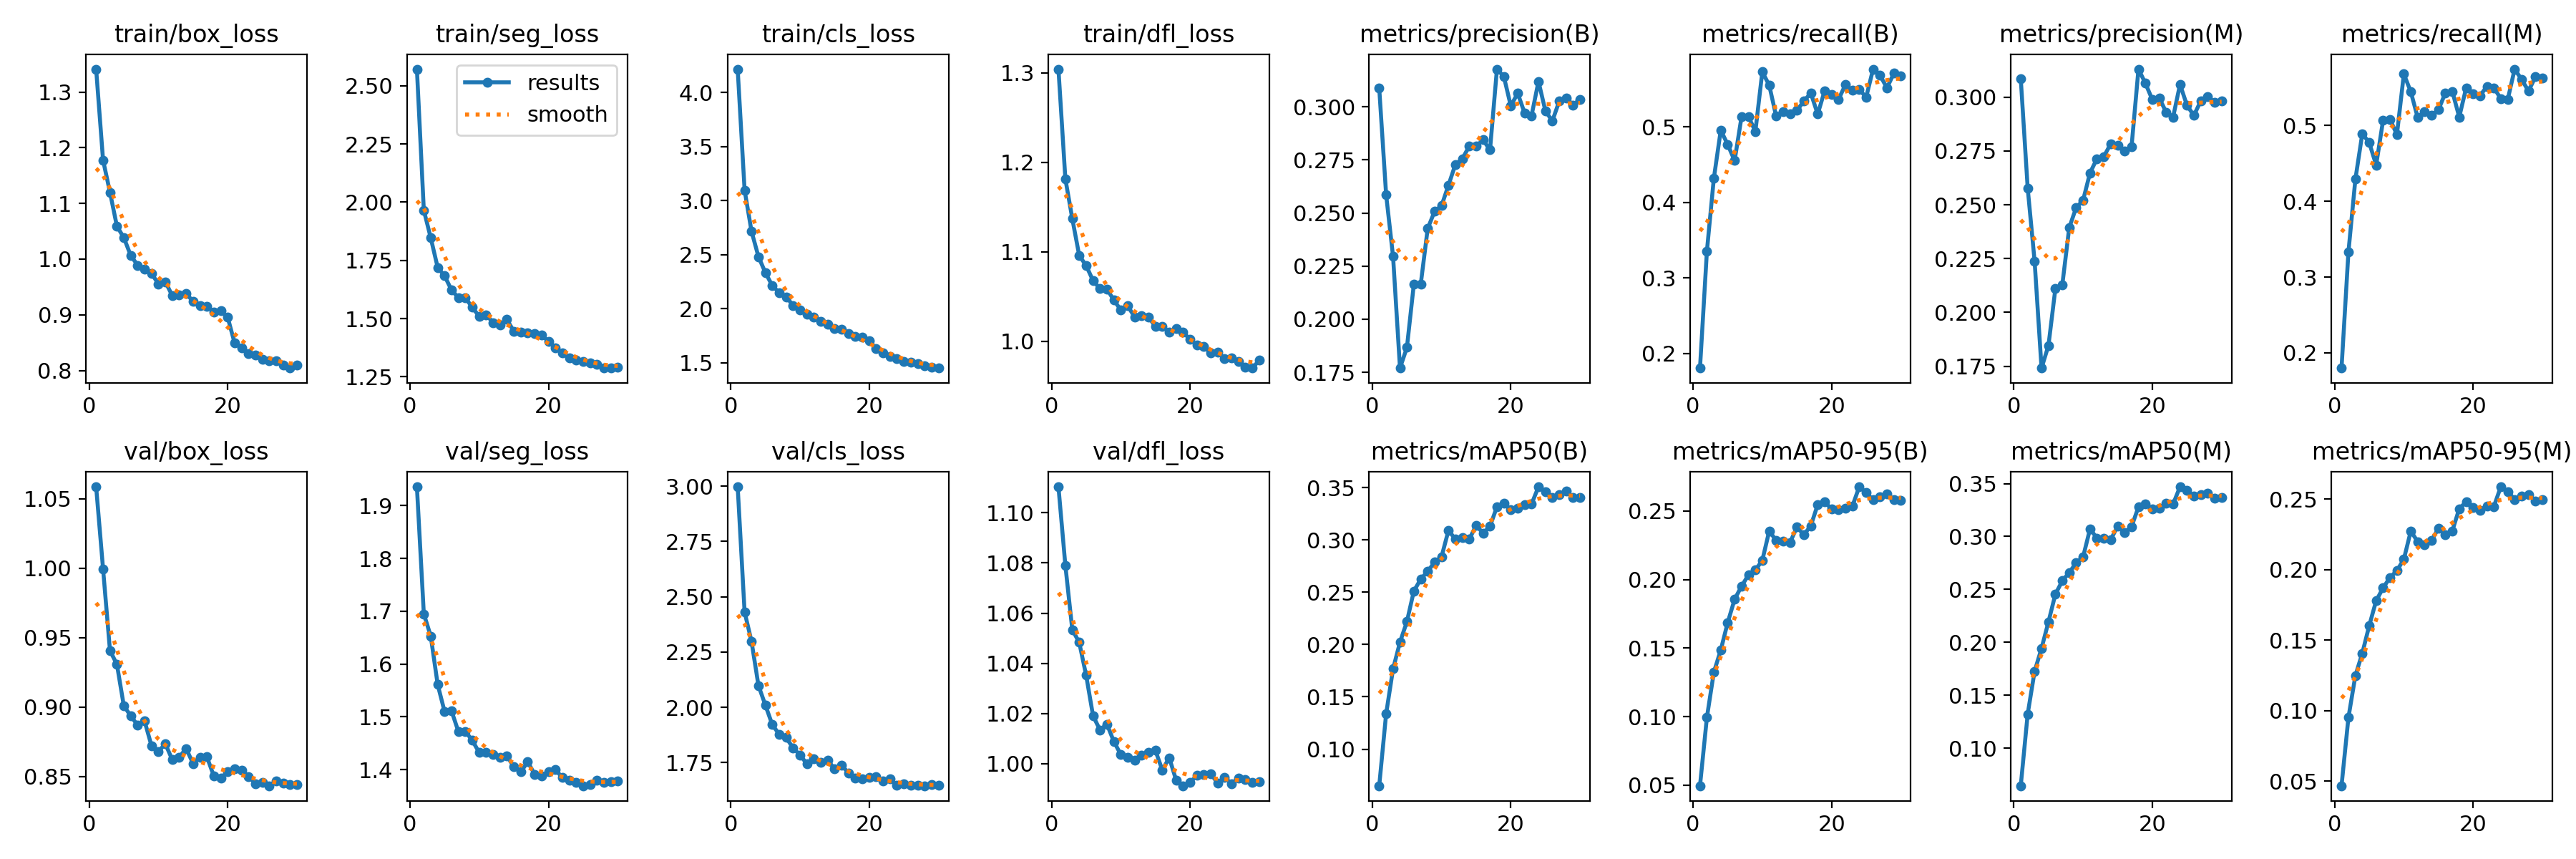

In [ ]:
# All training curves, metrics, and other results are stored as images in the 'runs' directory
from IPython.display import Image
Image("/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/Yolo_Result_Training/30_epochs-2/results.png")

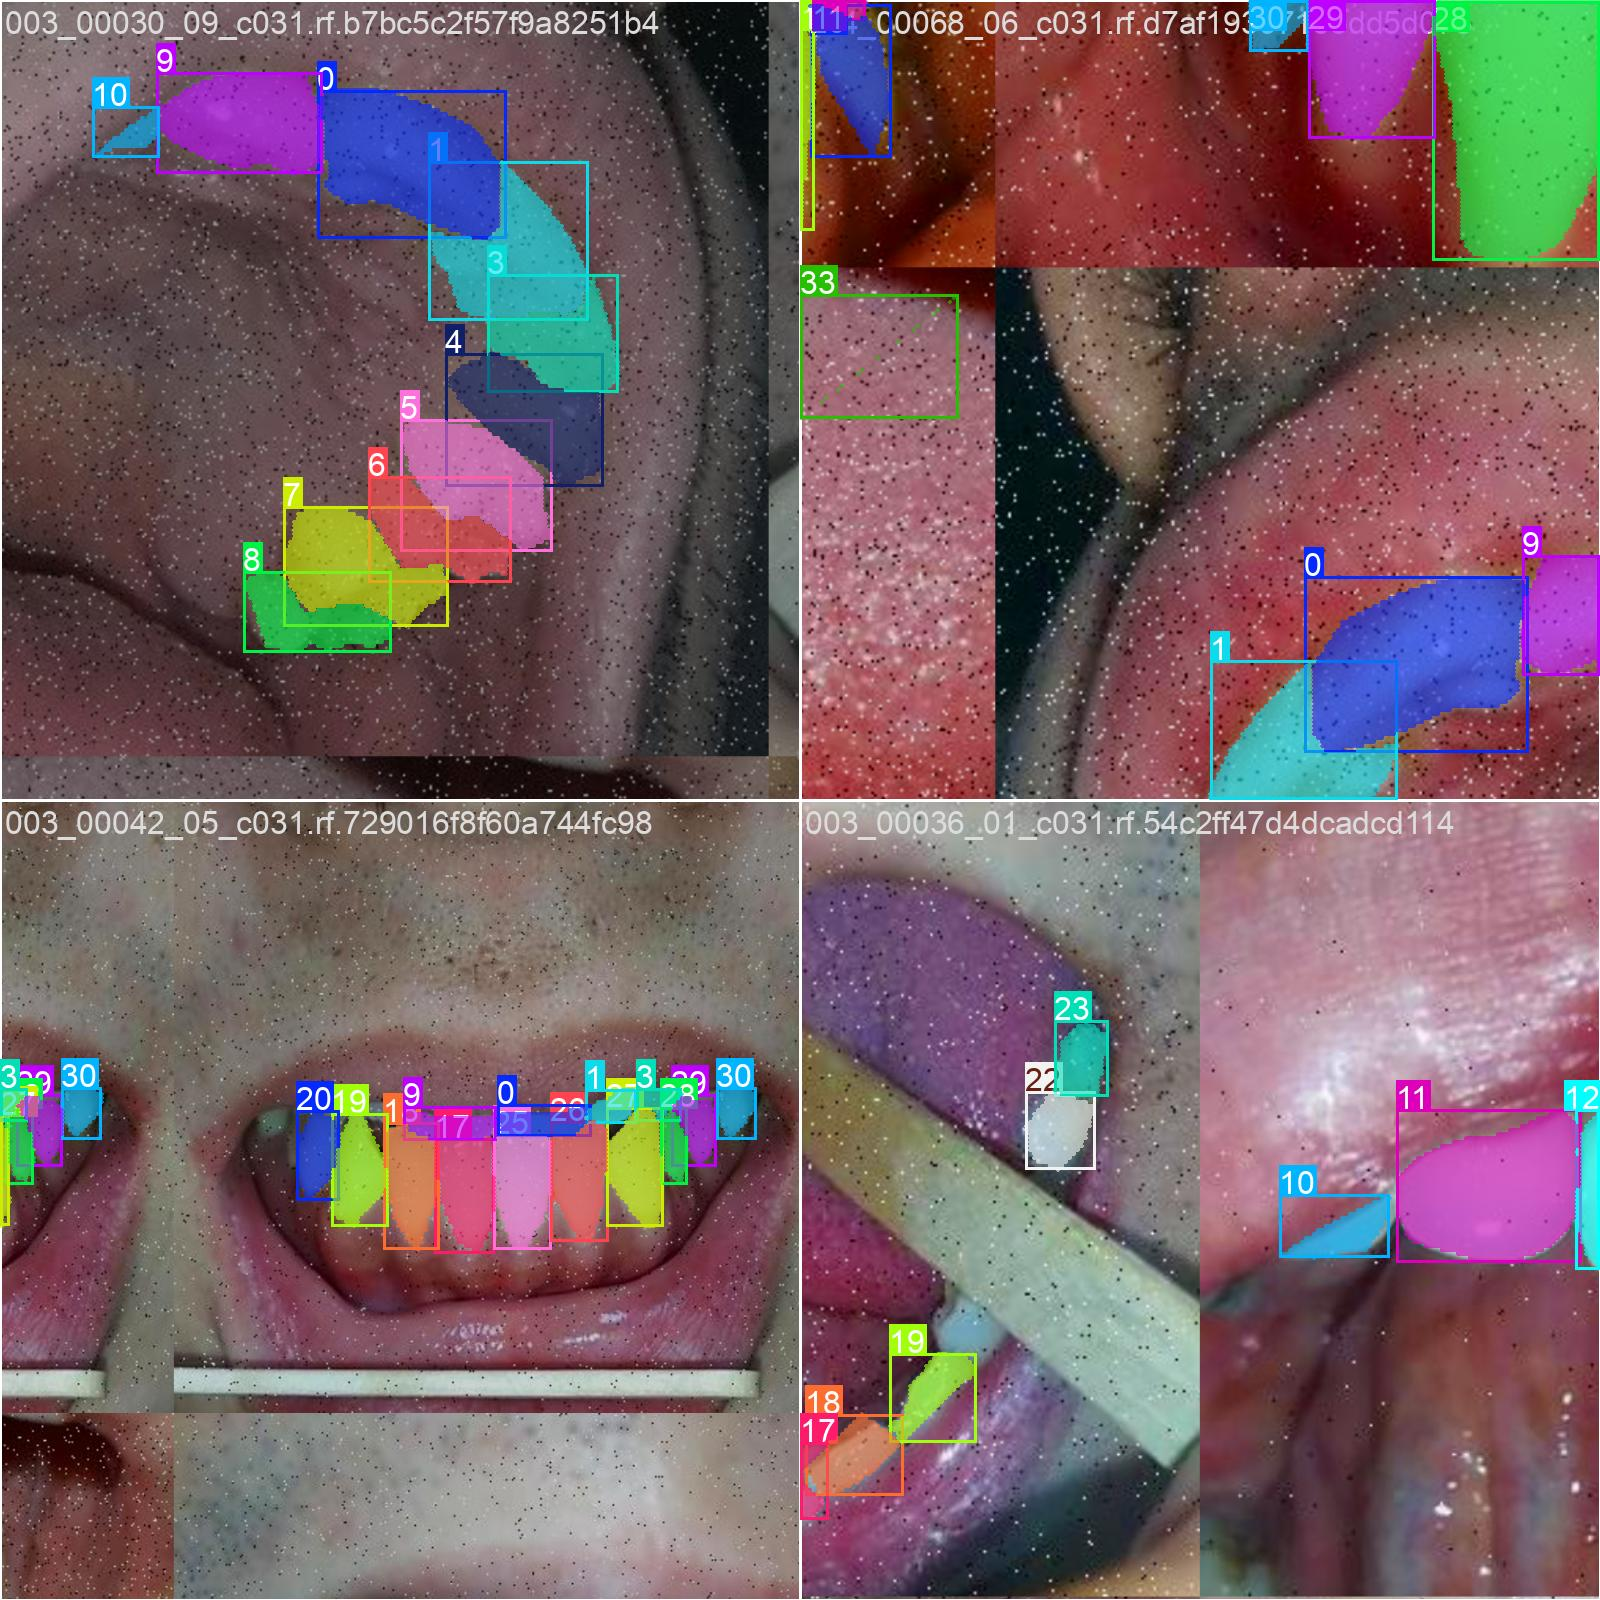

In [ ]:
Image(filename = "/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/Yolo_Result_Training/30_epochs-2/train_batch2.jpg", width=900)

## **Loading a test image from the directory u provided, and showing it and trying to segment it;**

In [ ]:
# now i am loading the last custom model --> /content/drive/MyDrive/YOLOv8_with_cell_+_mitochondria_+_alpha_granule_+_canalicular_vessels/results_of_training/200_epochs-/weights/last.pt
# .pt --> means pretrained weights;

In [ ]:
my_new_model = YOLO('/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/Yolo_Result_Training/30_epochs-2/weights/last.pt')


In [ ]:
new_image = '/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/TOOTHLENS_DATASET_missing_teeth_test_images/24261678245525054.jpeg' # loading a new test image;
new_results = my_new_model.predict(new_image, conf=0.01)  # predicting objects on that image by my trained model; conf=0.2 --> confidence score;



image 1/1 /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/TOOTHLENS_DATASET_missing_teeth_test_images/24261678245525054.jpeg: 576x800 2 31s, 3 32s, 4 33s, 3 34s, 2 35s, 1 36, 1 37, 1 38, 2 41s, 2 42s, 3 43s, 4 44s, 2 45s, 1 46, 2 47s, 46.7ms
Speed: 4.3ms preprocess, 46.7ms inference, 15.6ms postprocess per image at shape (1, 3, 576, 800)


### **The Test Image**

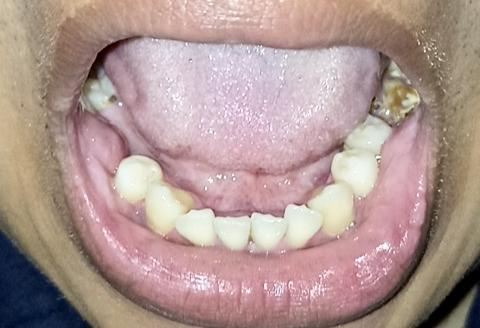

In [ ]:
# All training curves, metrics, and other results are stored as images in the 'runs' directory
from IPython.display import Image
Image("/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/TOOTHLENS_DATASET_missing_teeth_test_images/24261678245525054.jpeg")

### **Segmented Test Image**

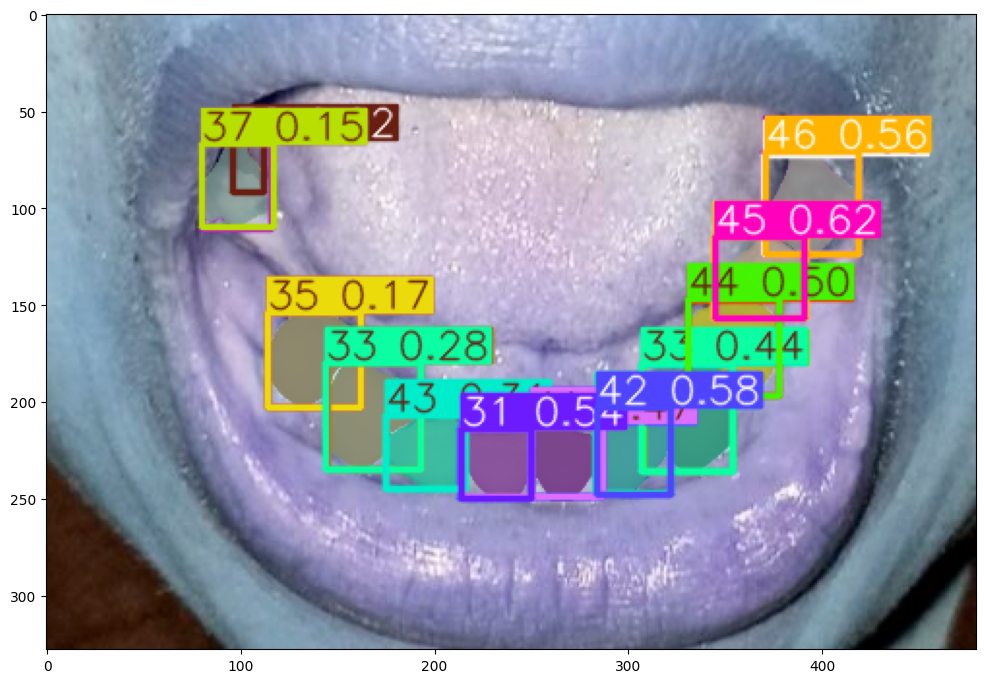

In [ ]:
# plotting;
new_result_array = new_results[0].plot()
plt.figure(figsize=(12, 12))
plt.imshow(new_result_array)

### As u can see, the segmented image from YOLOv8, it segmented all the teeth images correctly and **left the space where the tooth is missin**g,
### According to this result, the **missing teeth is : numbered 36**, as it is **missing** in between **35** and **36**;

It may not be accurate as "Ideal Doctor Inspection", but this is what i got from training the model multiple times;

In [ ]:
# larger text(default yolov8 visulaization settings)

In [ ]:
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load the trained model
my_new_model = YOLO('/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/Yolo_Result_Training/30_epochs-2/weights/last.pt')

# Directory containing all test images
test_images_directory = '/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/TOOTHLENS_DATASET_missing_teeth_test_images'

# Directory to save the segmented results
output_directory = '/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/result_segmented_yolov8_teeth_ToothLens'
os.makedirs(output_directory, exist_ok=True)

# Iterate through all images in the test directory
for image_filename in os.listdir(test_images_directory):
    if image_filename.endswith(".jpeg") or image_filename.endswith(".jpg") or image_filename.endswith(".png"):
        # Get the full path to the image
        image_path = os.path.join(test_images_directory, image_filename)

        # Predict objects on the image using the trained model
        new_results = my_new_model.predict(image_path, conf=0.01)  # Adjust confidence if needed

        # Plotting the result
        new_result_array = new_results[0].plot()

        # Save the segmented image result
        result_filename = os.path.splitext(image_filename)[0] + "_segmented.png"
        output_path = os.path.join(output_directory, result_filename)
        plt.imsave(output_path, new_result_array)

        print(f"Segmented result saved for: {image_filename}")

print("Segmentation of all images completed.")



image 1/1 /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/TOOTHLENS_DATASET_missing_teeth_test_images/46321675693636286.jpeg: 576x800 1 11, 1 14, 1 15, 1 18, 2 21s, 2 24s, 2 25s, 2 26s, 1 27, 1 28, 4 31s, 3 32s, 1 33, 2 34s, 5 35s, 1 36, 2 37s, 2 38s, 4 41s, 5 42s, 4 43s, 4 44s, 3 45s, 2 46s, 1 47, 1 48, 19.2ms
Speed: 3.1ms preprocess, 19.2ms inference, 24.2ms postprocess per image at shape (1, 3, 576, 800)
Segmented result saved for: 46321675693636286.jpeg

image 1/1 /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/TOOTHLENS_DATASET_missing_teeth_test_images/24261678245525054.jpeg: 576x800 2 31s, 3 32s, 4 33s, 3 34s, 2 35s, 1 36, 1 37, 1 38, 2 41s, 2 42s, 3 43s, 4 44s, 2 45s, 1 46, 2 47s, 18.3ms
Speed: 2.8ms preprocess, 18.3ms inference, 15.1ms postprocess per image at shape (1, 3, 576, 800)
Segmented result saved for: 24261678245525054.jpeg

image 1/1 /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/TOOTHLENS_DATASET_missing_teeth_test_imag

In [ ]:
# smaller texts :

In [ ]:
# /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/result_segmented_yolov8_teeth_ToothLens_v2

import os
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO

# Load the trained model
my_new_model = YOLO('/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/Yolo_Result_Training/30_epochs-2/weights/last.pt')

# Directory containing all test images
test_images_directory = '/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/TOOTHLENS_DATASET_missing_teeth_test_images'

# Directory to save the segmented results
output_directory = '/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/result_segmented_yolov8_teeth_ToothLens_v2'
os.makedirs(output_directory, exist_ok=True)

# Iterate through all images in the test directory
for image_filename in os.listdir(test_images_directory):
    if image_filename.endswith(".jpeg") or image_filename.endswith(".jpg") or image_filename.endswith(".png"):
        # Get the full path to the image
        image_path = os.path.join(test_images_directory, image_filename)

        # Predict objects on the image using the trained model
        new_results = my_new_model.predict(image_path, conf=0.01)  # Adjust confidence if needed

        # Convert result back to OpenCV format to modify text size
        result_image = new_results[0].plot()

        # Loop through the predictions and draw smaller text using OpenCV
        for box in new_results[0].boxes:
            class_id = int(box.cls.item())  # Extract scalar value from the tensor

            # Only show the FDI number (class name)
            fdi_number = my_new_model.names[class_id]

            # Extract coordinates from the box
            # Flatten the tensor and extract the coordinates
            x1, y1, x2, y2 = [int(coord.item()) for coord in box.xyxy[0]]  # Use .item() to extract each element

            # Change text size here (fontScale=0.5 for smaller text)
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.5  # Smaller font scale
            thickness = 1  # Thinner lines for the text

            # Draw the FDI number only (no confidence score)
            cv2.putText(result_image, fdi_number, (x1, y1 - 5), font, font_scale, (255, 255, 255), thickness)

        # Save the segmented image result with smaller text
        result_filename = os.path.splitext(image_filename)[0] + "_segmented_small_text.png"
        output_path = os.path.join(output_directory, result_filename)
        cv2.imwrite(output_path, result_image)

        print(f"Segmented result with FDI number saved for: {image_filename}")

print("Segmentation of all images with FDI numbers completed.")






image 1/1 /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/TOOTHLENS_DATASET_missing_teeth_test_images/46321675693636286.jpeg: 576x800 1 11, 1 14, 1 15, 1 18, 2 21s, 2 24s, 2 25s, 2 26s, 1 27, 1 28, 4 31s, 3 32s, 1 33, 2 34s, 5 35s, 1 36, 2 37s, 2 38s, 4 41s, 5 42s, 4 43s, 4 44s, 3 45s, 2 46s, 1 47, 1 48, 19.1ms
Speed: 3.8ms preprocess, 19.1ms inference, 23.9ms postprocess per image at shape (1, 3, 576, 800)
Segmented result with FDI number saved for: 46321675693636286.jpeg

image 1/1 /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/TOOTHLENS_DATASET_missing_teeth_test_images/24261678245525054.jpeg: 576x800 2 31s, 3 32s, 4 33s, 3 34s, 2 35s, 1 36, 1 37, 1 38, 2 41s, 2 42s, 3 43s, 4 44s, 2 45s, 1 46, 2 47s, 18.3ms
Speed: 3.5ms preprocess, 18.3ms inference, 17.5ms postprocess per image at shape (1, 3, 576, 800)
Segmented result with FDI number saved for: 24261678245525054.jpeg

image 1/1 /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/TOOTHLENS

In [ ]:
# segements the teeth images without CONFIDENCE SCORE AND BOUNDING BOX FOR BETTER VISUALIZATION, only FDI Number showed..

In [ ]:
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cv2

# Load the YOLO model
my_new_model = YOLO('/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/Yolo_Result_Training/30_epochs-2/weights/last.pt')

# Input and output directories
input_images_directory = '/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/TOOTHLENS_DATASET_missing_teeth_test_images'
output_directory = '/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/result_segmented_yolov8_teeth_ToothLens_v5'

# Ensure output directory exists
os.makedirs(output_directory, exist_ok=True)

# Process each image in the directory
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_results = my_new_model.predict(image_path)  # Predicting objects on the image

    # Load the image
    img = cv2.imread(image_path)

    # Loop through the results
    for box in new_results[0].boxes:
        class_id = int(box.cls)
        # Only show the FDI number (class name)
        fdi_number = my_new_model.names[class_id]

        # Extract coordinates from the box
        coords = box.xyxy[0].tolist()  # Ensure it's a list
        x1, y1, x2, y2 = map(int, coords)

        # Draw the FDI number on the image without bounding box and confidence score
        cv2.putText(img, fdi_number, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)  # Smaller text

    # Save the modified image to the output directory
    output_path = os.path.join(output_directory, image_filename)
    cv2.imwrite(output_path, img)

print("Segmentation of all images completed.")



image 1/1 /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/TOOTHLENS_DATASET_missing_teeth_test_images/46321675693636286.jpeg: 576x800 1 31, 1 32, 1 34, 1 35, 1 36, 1 37, 2 38s, 2 41s, 2 42s, 3 44s, 1 45, 19.9ms
Speed: 9.1ms preprocess, 19.9ms inference, 9.3ms postprocess per image at shape (1, 3, 576, 800)

image 1/1 /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/TOOTHLENS_DATASET_missing_teeth_test_images/24261678245525054.jpeg: 576x800 2 31s, 1 32, 2 33s, 1 34, 1 35, 1 36, 2 41s, 1 42, 1 43, 1 44, 1 45, 1 46, 19.2ms
Speed: 4.1ms preprocess, 19.2ms inference, 9.3ms postprocess per image at shape (1, 3, 576, 800)

image 1/1 /content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/TOOTHLENS_DATASET_missing_teeth_test_images/98361680105918709.jpeg: 576x800 2 31s, 2 32s, 2 33s, 1 37, 2 41s, 2 42s, 2 43s, 2 44s, 1 45, 20.4ms
Speed: 4.2ms preprocess, 20.4ms inference, 10.0ms postprocess per image at shape (1, 3, 576, 800)

image 1/1 /content/drive/MyDri

In [ ]:
new_result = new_results[0]
new_result

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: '11', 1: '12', 2: '12-', 3: '13', 4: '14', 5: '15', 6: '16', 7: '17', 8: '18', 9: '21', 10: '22', 11: '23', 12: '24', 13: '25', 14: '26', 15: '27', 16: '28', 17: '31', 18: '32', 19: '33', 20: '34', 21: '35', 22: '36', 23: '37', 24: '38', 25: '41', 26: '42', 27: '43', 28: '44', 29: '45', 30: '46', 31: '47', 32: '48', 33: 'C1', 34: 'PDI1'}
obb: None
orig_img: array([[[170, 196, 210],
        [172, 198, 212],
        [168, 194, 208],
        ...,
        [138, 157, 170],
        [141, 160, 173],
        [144, 163, 176]],

       [[169, 195, 209],
        [171, 197, 211],
        [166, 192, 206],
        ...,
        [141, 160, 173],
        [146, 165, 178],
        [149, 168, 181]],

       [[169, 195, 209],
        [169, 195, 209],
        [165, 191, 205],
        ...,
        [145, 164, 177],
        [150, 16

In [ ]:
new_result.masks.xyn # 'Masks.xyn' --> segments (normalized), 'Masks.xy' --> segments (pixels); extracting bounding polygons

[array([[    0.76375,        0.35],
        [    0.76375,     0.35549],
        [     0.7625,     0.35732],
        [     0.7625,     0.35915],
        [    0.75375,     0.37195],
        [     0.7525,     0.37195],
        [    0.74875,     0.37744],
        [     0.7475,     0.37744],
        [     0.7425,     0.38476],
        [     0.7425,     0.38659],
        [      0.725,      0.4122],
        [      0.725,     0.41402],
        [     0.7225,     0.41768],
        [     0.7175,     0.41768],
        [     0.7175,     0.45061],
        [    0.73625,     0.45061],
        [     0.7375,     0.44878],
        [      0.745,     0.44878],
        [    0.74625,     0.45061],
        [      0.755,     0.45061],
        [    0.75625,     0.45244],
        [    0.76125,     0.45244],
        [     0.7625,     0.45427],
        [      0.765,     0.45427],
        [    0.76625,      0.4561],
        [    0.76875,      0.4561],
        [       0.77,     0.45793],
        [    0.77125,     0.

In [ ]:
# extracting segmented masks;
extracted_masks = new_result.masks.data

In [ ]:
extracted_masks.shape

torch.Size([33, 576, 800])

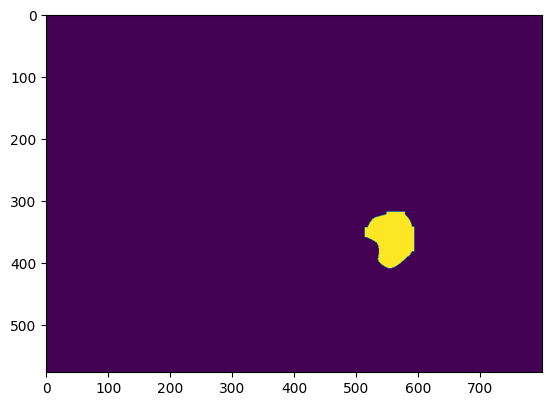

In [ ]:
masks_array = extracted_masks.cpu().numpy()


plt.imshow(masks_array[9])

In [ ]:
# Extract the boxes, which likely contain class IDs
detected_boxes = new_result.boxes.data
# Extract class IDs from the detected boxes
class_labels = detected_boxes[:, -1].int().tolist()
# Initialize a dictionary to hold masks by class
masks_by_class = {name: [] for name in new_result.names.values()}

# Iterate through the masks and class labels
for mask, class_id in zip(extracted_masks, class_labels):
    class_name = new_result.names[class_id]  # Map class ID to class name
    masks_by_class[class_name].append(mask.cpu().numpy())


for class_name, masks in masks_by_class.items():
    print(f"Class Name: {class_name}, Number of Masks: {len(masks)}")

Class Name: 11, Number of Masks: 0
Class Name: 12, Number of Masks: 0
Class Name: 12-, Number of Masks: 0
Class Name: 13, Number of Masks: 0
Class Name: 14, Number of Masks: 0
Class Name: 15, Number of Masks: 0
Class Name: 16, Number of Masks: 0
Class Name: 17, Number of Masks: 0
Class Name: 18, Number of Masks: 0
Class Name: 21, Number of Masks: 0
Class Name: 22, Number of Masks: 0
Class Name: 23, Number of Masks: 0
Class Name: 24, Number of Masks: 0
Class Name: 25, Number of Masks: 0
Class Name: 26, Number of Masks: 0
Class Name: 27, Number of Masks: 0
Class Name: 28, Number of Masks: 0
Class Name: 31, Number of Masks: 2
Class Name: 32, Number of Masks: 3
Class Name: 33, Number of Masks: 4
Class Name: 34, Number of Masks: 3
Class Name: 35, Number of Masks: 2
Class Name: 36, Number of Masks: 1
Class Name: 37, Number of Masks: 1
Class Name: 38, Number of Masks: 1
Class Name: 41, Number of Masks: 2
Class Name: 42, Number of Masks: 2
Class Name: 43, Number of Masks: 3
Class Name: 44, Num

In [ ]:
import pandas as pd
from skimage.measure import regionprops

# Initialize a list to store the properties
props_list = []

# Iterate through all classes
for class_name, masks in masks_by_class.items():
    # Iterate through the masks for this class
    for mask in masks:
        # Convert the mask to an integer type if it's not already
        mask = mask.astype(int)

        # Apply regionprops to the mask
        props = regionprops(mask)

        # Extract the properties you want (e.g., area, perimeter) and add them to the list
        for prop in props:
            area = prop.area
            perimeter = prop.perimeter
            # Add other properties as needed

            # Append the properties and class name to the list
            props_list.append({'Class Name': class_name, 'Area': area, 'Perimeter': perimeter})

# Convert the list of dictionaries to a DataFrame
props_df = pd.DataFrame(props_list)

In [ ]:
props_df.to_csv('/content/drive/MyDrive/ToothLens_Trial_Missing_Tooth_Detection/Yolo_Result_Training/YOLOv8_object_properties.csv', index=False)


In [ ]:
props_df

,Class Name,Area,Perimeter
0,31,3014.0,222.325902
1,31,3081.0,225.639610
2,32,3656.0,244.267027
3,32,3097.0,225.053824
4,32,2947.0,222.396970
5,33,5091.0,294.551299
6,33,5211.0,297.622366
7,33,3369.0,228.468037
8,33,3641.0,243.681241
9,34,4894.0,281.722871
